In [89]:
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
import operator
from pydantic import BaseModel, Field
from IPython.display import Image, display


import os
from dotenv import load_dotenv
load_dotenv()

True

In [90]:
tavily_api_key = os.getenv("tavily_api_key")
groq_api_key = os.getenv("groq_api_key")
langchain_api_key = os.getenv("langchain_api_key")
langchain_project = os.getenv("langchain_project")
serper_api_key = os.getenv("serper_api_key")
google_api_key = os.getenv("google_api_key")

In [91]:
os.environ["tavily_api_key"] = tavily_api_key
os.environ["groq_api_key"] = groq_api_key 
os.environ["langchain_api_key"] = langchain_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["langchain_endpoint"] = "https://api.smith.langchain.com"
os.environ["tavily_api_key"] = tavily_api_key
os.environ["google_api_key"] = google_api_key

In [92]:
embeddings = GoogleGenerativeAIEmbeddings(model= "models/embedding-001")
llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")

In [93]:
loader = DirectoryLoader("ReAct_agent_from_scratch\data2", glob='*.txt', loader_cls=TextLoader)
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size= 100,
    chunk_overlap = 50
)
new_docs = text_splitter.split_documents(documents= docs)
doc_strings = [doc.page_content for doc in new_docs]

In [94]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs= {"k":3})

In [95]:
class AgentState(TypedDict):
    # the message field should be a sequence of strings, and we annotate it with 'operator.add'
    # this implies we might want to "add" new messages to the sequence later
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [96]:
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description= 'Reasoning behind topic selection' )

In [97]:
parser = PydanticOutputParser(pydantic_object= TopicSelectionParser)

In [98]:
def function_1(state):
    messages = state["messages"]
    question = messages[-1]
    
    template ="""
    Your task is to classify the given user query into one of the following categories: [Tunisia, Not Related].
    Only respond with the category name and nothing else.
    
    user query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(
        template= template,
        input_variables=["question", "format_instructions"]

    )
    chain = prompt | llm | parser
    response = chain.invoke({"question": question, "format_instructions": parser.get_format_instructions()})
    print (response)
    return {"messages": [response.Topic]}

In [99]:
def router(state):
    print('->Router->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'Tunisia' in last_message:
        return 'Rag call'
    else:
        return 'LLM call'

In [100]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0]
    print(question)
    
    template = """Answer the question based only on the following context:
    {context}
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    print(prompt)
    
    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        |StrOutputParser()
    )
    result = retrieval_chain.invoke(question)
    return {"messages": [result]}
    

In [101]:
def function_3(state):
    print('-> Calling LLM ->')
    
    messages = state['messages']
    question = messages[0]
    
    #Normal LLM call
    
    complete_query = "Answer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [102]:
workflow5 = StateGraph(AgentState)

workflow5.add_node("agent", function_1)
workflow5.add_node("RAG", function_2)
workflow5.add_node("LLM" , function_3)

workflow5.set_entry_point("agent")
workflow5.add_conditional_edges(
    "agent",
    router,
    {
    "Rag call": "RAG",
    "LLM call": "LLM"
    }
)
workflow5.add_edge("RAG", END)
workflow5.add_edge("LLM", END)
app5 = workflow5.compile()

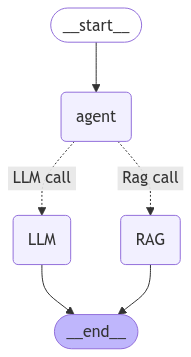

In [103]:
try:
    display(Image(app5.get_graph().draw_mermaid_png()))
except:
    print(e)

In [116]:
inputs = {"messages": [" tell me about the tunisian economic growth"]}

In [117]:
output = app5.invoke(inputs)

Topic='Tunisia' Reasoning='The query mentions the Tunisian economy, which is related to Tunisia.'
->Router->
Tunisia
-> Calling RAG ->
 tell me about the tunisian economic growth
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n    Question: {question}\n    '), additional_kwargs={})]


In [118]:
output

{'messages': [' tell me about the tunisian economic growth',
  'Tunisia',
  'The provided text does not contain information about the Tunisian economic growth.']}

In [119]:
inputs_2 = {"messages": ["tell me about the american ecnomic growth"]}

In [120]:
output = app5.invoke(inputs_2)

Topic='Not Related' Reasoning='The user query is about the American economic growth, which is not related to Tunisia.'
->Router->
Not Related
-> Calling LLM ->


In [121]:
output

{'messages': ['tell me about the american ecnomic growth',
  'Not Related',
  '**American Economic Growth**\n\n**Historical Context:**\n\n* The United States has experienced periods of rapid economic growth throughout its history.\n* The Industrial Revolution in the 19th century led to the expansion of manufacturing and transportation, fueling significant growth.\n* In the 20th century, the Great Depression and World War II had a profound impact on the economy, but the post-war period saw a period of sustained economic expansion known as the "Golden Age of Capitalism."\n\n**Key Factors Contributing to Economic Growth:**\n\n* **Innovation and Technology:** The United States has historically been a leader in innovation and technological advancements, driving economic progress.\n* **Natural Resources:** The country\'s vast natural resources, including land, minerals, and energy, have contributed to its economic development.\n* **Entrepreneurship and Free Markets:** A strong entrepreneuria

In [122]:
inputs_3 = {"messages": ["where was carthage located"]}

In [123]:
output = app5.invoke(inputs_3)

Topic='Tunisia' Reasoning='The user query is about the location of Carthage, which is in Tunisia.'
->Router->
Tunisia
-> Calling RAG ->
where was carthage located
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n    Question: {question}\n    '), additional_kwargs={})]


In [124]:
output

{'messages': ['where was carthage located',
  'Tunisia',
  'The provided context does not mention the location of Carthage, so I cannot answer this question from the provided context.']}